<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/pytorch-mnist-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
"""
Import necessary libraries to create a variational autoencoder
The code is mainly developed using the PyTorch library
"""
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

In [67]:
"""
Determine if any GPUs are available 
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import os
# set the current working directory
path = '/content/drive/MyDrive/PML_2023/'
os.chdir(path)

In [70]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

In [71]:
"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
#    batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)

In [72]:
#A Convolutional Variational Autoencoder

class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        
        # Initializing the 2 convolutional layers and 2 fully-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5) 
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    

In [73]:
"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [74]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch {}: Loss {}'.format(epoch, loss))
        

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: ignored

In [75]:
#torch.save(net, '20230418_ConvNet_cpu.pt')
net = torch.load(path + '20230418_ConvNet_cpu.pt')

In [76]:
!ls

20230415_ConvNet.pt    20230416_VAE.pt		data
20230415_Diffusion.pt  20230418_ConvNet_cpu.pt	mnist_data
20230415_VAE.pt        20230418_ConvNet.pt	synthetic_dataloader.pth
20230416_ConvNet.pt    ConvNet.pt		synthetic_loader.pth


In [77]:
device

device(type='cpu')

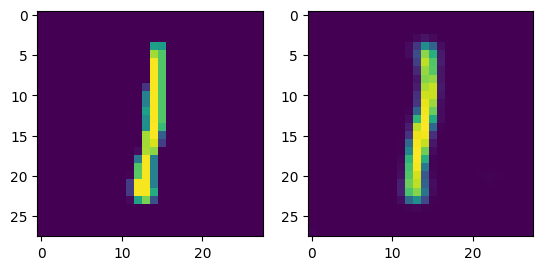

In [78]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

### Calculate RMSE and MLP classification accuracy

Consolidate train images + labels

In [79]:
"""
reload training set with batch size = 1
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)
    batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)

In [80]:
images = []
for batch in train_loader:
    images.append(batch[0])
train_images = torch.cat(images, dim=0)

train_labels = []
for _, label in train_loader:
    train_labels.append(label)

In [81]:
len(train_labels)

60000

In [82]:
train_labels = torch.as_tensor(train_labels, dtype=torch.float)
print(train_labels.dtype)
print(len(list(train_labels)))

torch.float32
60000


Consolidate test images + labels

In [83]:
images = []
for batch in test_loader:
    images.append(batch[0])
test_images = torch.cat(images, dim=0)

test_labels = []
for _, label in test_loader:
    test_labels.append(label)
test_labels = torch.as_tensor(test_labels, dtype=torch.float)
test_labels = test_labels.type(torch.LongTensor)   # casting to long
print(len(test_labels))
print(test_labels.size())
print(test_labels.dtype)

10000
torch.Size([10000])
torch.int64


Candidate Synthetic loader

In [87]:
# Create an empty tensor to store the synthetic images
synthetic_images = torch.empty((len(test_loader), 1, 28, 28), dtype=torch.float32, device=device)

# Evaluate the Conv Net VAE model on the test dataset and generate synthetic images
net.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        synthetic_image = net(image)[0].squeeze()
        synthetic_images[i] = synthetic_image

# h/t https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/
# set up DataLoader for training set
synthetic_loader = DataLoader(list(zip(synthetic_images, test_labels)), shuffle=False, batch_size=100)
torch.save(synthetic_loader, "20230419_synthetic_ConvNet_VAE_loader.pth")


#Create Feed-forward Neural Network for supervised training

In [88]:
# Define the neural network architecture
class MNISTFeedForward(nn.Module):
    def __init__(self):
        super(MNISTFeedForward, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = torch.log_softmax(self.fc3(x), dim=0)
        return x

In [105]:
torch.manual_seed(42)

# Define hyperparameters
batch_size = 64
epochs =30
learning_rate = 0.001

# Load the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [106]:
# Initialize the model, loss function, and optimizer
model = MNISTFeedForward()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [107]:
#synthetic_loader = torch.load("synthetic_ConvNet_VAE_loader.pth")

In [108]:
# Train the model
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(synthetic_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print('Epoch [{} / {}], Loss: {:.4f}'.format(epoch + 1, epochs, loss.item()))

Epoch [1 / 30], Loss: 0.5240
Epoch [2 / 30], Loss: 0.4514
Epoch [3 / 30], Loss: 0.4447
Epoch [4 / 30], Loss: 0.4245
Epoch [5 / 30], Loss: 0.3807
Epoch [6 / 30], Loss: 0.3269
Epoch [7 / 30], Loss: 0.2748
Epoch [8 / 30], Loss: 0.2269
Epoch [9 / 30], Loss: 0.1819
Epoch [10 / 30], Loss: 0.1503
Epoch [11 / 30], Loss: 0.1236
Epoch [12 / 30], Loss: 0.0977
Epoch [13 / 30], Loss: 0.0796
Epoch [14 / 30], Loss: 0.0684
Epoch [15 / 30], Loss: 0.0589
Epoch [16 / 30], Loss: 0.0441
Epoch [17 / 30], Loss: 0.0305
Epoch [18 / 30], Loss: 0.0328
Epoch [19 / 30], Loss: 0.0213
Epoch [20 / 30], Loss: 0.0208
Epoch [21 / 30], Loss: 0.0172
Epoch [22 / 30], Loss: 0.0144
Epoch [23 / 30], Loss: 0.0099
Epoch [24 / 30], Loss: 0.0077
Epoch [25 / 30], Loss: 0.0081
Epoch [26 / 30], Loss: 0.0064
Epoch [27 / 30], Loss: 0.0059
Epoch [28 / 30], Loss: 0.0053
Epoch [29 / 30], Loss: 0.0048
Epoch [30 / 30], Loss: 0.0061


In [109]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print('Accuracy on test dataset (called training): {:.2f}%'.format(accuracy))

Accuracy on test dataset (called training): 94.23%


## Load generic VAE for comparison

In [110]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

In [111]:
# Hyper-parameters
image_size = 784
bs = 128
#h_dim = 400
#z_dim = 20
num_epochs = 50
x_dim=784, 
h_dim1= 512, 
h_dim2=256, 
z_dim=2
learning_rate = 1e-3

In [112]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [113]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
#vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=2)
vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

In [114]:
vae.parameters

<bound method Module.parameters of VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)>

In [115]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [116]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
          data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [117]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
              data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [118]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.186890
Train Epoch: 1 [12800/60000 (21%)]	Loss: 186.025314
Train Epoch: 1 [25600/60000 (43%)]	Loss: 171.031921
Train Epoch: 1 [38400/60000 (64%)]	Loss: 167.876816
Train Epoch: 1 [51200/60000 (85%)]	Loss: 164.173523
====> Epoch: 1 Average loss: 182.6214
====> Test set loss: 163.8734
Train Epoch: 2 [0/60000 (0%)]	Loss: 166.553177
Train Epoch: 2 [12800/60000 (21%)]	Loss: 166.583862
Train Epoch: 2 [25600/60000 (43%)]	Loss: 163.813690
Train Epoch: 2 [38400/60000 (64%)]	Loss: 160.499573
Train Epoch: 2 [51200/60000 (85%)]	Loss: 162.174866
====> Epoch: 2 Average loss: 160.3782
====> Test set loss: 157.2428
Train Epoch: 3 [0/60000 (0%)]	Loss: 158.537888
Train Epoch: 3 [12800/60000 (21%)]	Loss: 158.172745
Train Epoch: 3 [25600/60000 (43%)]	Loss: 149.648590
Train Epoch: 3 [38400/60000 (64%)]	Loss: 154.930054
Train Epoch: 3 [51200/60000 (85%)]	Loss: 150.364929
====> Epoch: 3 Average loss: 154.8924
====> Test set loss: 153.4420
Train Epoch: 4 [0/60000 (0%)]	L

In [119]:
torch.save(vae, '20230419_VAE.pt')
#vae = torch.load(path + '20230415_VAE.pt')

In [180]:
# store ground truth test images
test_images_ground_truth, _ = next(iter(test_loader))
test_images_ground_truth = test_images_ground_truth[-12:,:,:,:] #grab 12 last images



torch.Size([1, 1, 28, 28])


Ground truth images reformatted are of dimension torch.Size([12, 1, 28, 28])
Concatenated object containing both ground truth & generic VAE is of size torch.Size([12, 784])
Concatenated object also containing ConvNet VAE is of size torch.Size([36, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.FloatTensor


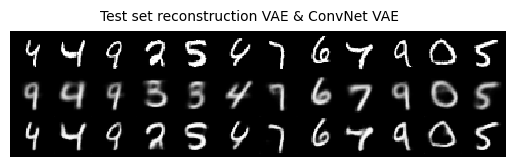

torch.Size([36, 1, 28, 28])


In [122]:
## now create an image of estimated images and ground truth
# h/t https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

## run first five training images through the encoder
### from https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.suptitle('Test set reconstruction VAE & ConvNet VAE', fontsize=10, y=.67)
    plt.axis('off')
    plt.show()

def plot_reconstruction(vae, n=12):
    
    x = test_images_ground_truth
    x = x[:n,:,:,:].to(device)
    print("Ground truth images reformatted are of dimension", x.size())
    try:
        out, _, _, log_p = vae(x.view(-1, image_size)) 
    except:
        out, _, _ = vae(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object containing both ground truth & generic VAE is of size", out.size())
    ##
    out, mu, logVAR = net(x)
    
    
    x_concat = torch.cat([x_concat, out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object also containing ConvNet VAE is of size", x_concat.size())

    print(out.size())
    print(out.type())
    ##
    out_grid = torchvision.utils.make_grid(x_concat, nrow=12)#.cpu().data
    show(out_grid)
    print(x_concat.size())

plot_reconstruction(vae)

# Generate synthetic data for generic VAE implementation

In [162]:
"""
reload training set with batch size = 1
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)
    batch_size=1, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)
'''

from torchvision import datasets, transforms

# Define a custom transformation to reshape the tensor
reshape_transform = transforms.Lambda(lambda x: x.view(1, 28, 28))

# Load the MNIST dataset with the custom transformation applied
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        reshape_transform
    ])),
    batch_size=1)
'''

"\n\nfrom torchvision import datasets, transforms\n\n# Define a custom transformation to reshape the tensor\nreshape_transform = transforms.Lambda(lambda x: x.view(1, 28, 28))\n\n# Load the MNIST dataset with the custom transformation applied\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('data', train=False, transform=transforms.Compose([\n        transforms.ToTensor(),\n        reshape_transform\n    ])),\n    batch_size=1)\n"

In [183]:
# Create an empty tensor to store the synthetic images
synthetic_images = torch.empty((len(test_loader), 1, 28, 28), dtype=torch.float32, device=device)
synthetic_images.size()

vae.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        #image = image.view(-1, 28 * 28)
        synthetic_image, mu, log_var  = vae(image)

        #recon_batch, mu, log_var = vae(data)
        #synthetic_image = vae(image.view(-1, image_size))

        synthetic_image = synthetic_image.view(-1, 28, 28)

        #out.view(-1, 1, 28, 28)

In [184]:
print(image.size())
print(synthetic_image.size())

torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


In [195]:
# Evaluate the Conv Net VAE model on the test dataset and generate synthetic images
vae.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        
        synthetic_image = vae(image)[0]#.squeeze()
        synthetic_images[i] = synthetic_image.view(1, 1, 28, 28)

# set up DataLoader for training set
synthetic_generic_VAE_loader = DataLoader(list(zip(synthetic_images, test_labels)), shuffle=False, batch_size=100)
torch.save(synthetic_generic_VAE_loader, "20230419_synthetic_generic_VAE_loader.pth")

AttributeError: ignored

In [192]:
print(synthetic_image.size())
print(synthetic_images.size())

torch.Size([1, 784])
torch.Size([10000, 1, 28, 28])


In [196]:
# Train the model
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(synthetic_generic_VAE_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print('Epoch [{} / {}], Loss: {:.4f}'.format(epoch + 1, epochs, loss.item()))

Epoch [1 / 30], Loss: 2.2610
Epoch [2 / 30], Loss: 2.2610
Epoch [3 / 30], Loss: 2.2610
Epoch [4 / 30], Loss: 2.2610
Epoch [5 / 30], Loss: 2.2610
Epoch [6 / 30], Loss: 2.2610
Epoch [7 / 30], Loss: 2.2610
Epoch [8 / 30], Loss: 2.2610
Epoch [9 / 30], Loss: 2.2610
Epoch [10 / 30], Loss: 2.2610
Epoch [11 / 30], Loss: 2.2610
Epoch [12 / 30], Loss: 2.2610
Epoch [13 / 30], Loss: 2.2610
Epoch [14 / 30], Loss: 2.2610
Epoch [15 / 30], Loss: 2.2610
Epoch [16 / 30], Loss: 2.2610
Epoch [17 / 30], Loss: 2.2610
Epoch [18 / 30], Loss: 2.2610
Epoch [19 / 30], Loss: 2.2610
Epoch [20 / 30], Loss: 2.2610
Epoch [21 / 30], Loss: 2.2610
Epoch [22 / 30], Loss: 2.2610
Epoch [23 / 30], Loss: 2.2610


KeyboardInterrupt: ignored

In [154]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print('Accuracy on test dataset (called training): {:.2f}%'.format(accuracy))

Accuracy on test dataset (called training): 94.23%


# [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for MNIST
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.permute(1,2,0).numpy() for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [ ]:
class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c))

def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2), 
                         MyConv((in_c//2, size, size), in_c//2, in_c//4), 
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))

In [ ]:
class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock(size, in_c, 10)
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock(size//2, 10, 20)
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock(size//4, 20, 40)
        self.down3 = nn.Conv2d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv((40, size//8, size//8), 40, 20),
            MyConv((20, size//8, size//8), 20, 20),
            MyConv((20, size//8, size//8), 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp(size//4, 80)
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp(size//2, 40)
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock(size, 20, 10)
        self.conv_out = nn.Conv2d(10, out_c, 3, 1, 1)

    def forward(self, x, t): # x is (bs, in_c, size, size) t is (bs)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (bs, 20, size/4, size/4)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (bs, 80, size/8, size/8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (bs, 20, size/8, size/8)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (bs, 40, size/4, size/4)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (bs, 20, size, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (bs, 10, size, size)
        out = self.conv_out(out) # (bs, out_c, size, size)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

In [ ]:
bs = 3
x = torch.randn(bs,1,32,32)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1, size=32)

In [ ]:
y = unet(x,timesteps)
y.shape

In [ ]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps] # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
        s1 = s1.reshape(-1,1,1,1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1) # (bs, 1, 1, 1)
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

In [ ]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [ ]:
betas[timesteps]

In [ ]:
betas[10]

In [ ]:
betas[timesteps].reshape(-1,1,1,1).shape

In [ ]:
network = MyTinyUNet(in_c =1, out_c =1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [ ]:
bs = 5
x = torch.randn(bs,1,32,32).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [ ]:
timesteps.shape

In [ ]:
y = model.add_noise(x,x,timesteps)
y.shape

In [ ]:
y = model.step(x,timesteps[0],x)
y.shape

You can check that all the parameters of the UNet network are indeed parameters of the DDPM model like this:

In [ ]:
for n, p in model.named_parameters():
    print(n, p.shape)

In [ ]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()

In [ ]:
root_dir = './data/'
transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=4096, shuffle=True, num_workers=10)

In [ ]:
for b in dataloader:
    batch = b[0]
    break

bn = [b for b in batch[:100]] 
show_images(bn, "origin")

In [ ]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
network = MyTinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)        

In [ ]:
#torch.save(model, '20230415_Diffusion.pt')
model = torch.load(path + '20230416_Diffusion.pt')

In [ ]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size,1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t==500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [ ]:
generated, generated_mid = generate_image(model, 100, 1, 32)

In [ ]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")

In [ ]:
def rescale(x):
    return (x+1)/2

def show_images_rescale(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [rescale((im.permute(1,2,0)).numpy()) for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                #plt.imshow(images[idx].reshape(pixel, pixel, n_channels), cmap="gray")
                plt.imshow(images[idx])
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

In [ ]:
show_images_rescale(generated, "Final result")

# Probabilistic PCA

### Generic PCA Elbow Plot

In [197]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [198]:
## from PCA

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
'''
### from generic VA
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
'''

In [199]:
def get_data_matrix(dataloader):
    data_matrix = []
    for i, (images, labels) in enumerate(dataloader):
        images = images.view(-1, 28 * 28)
        data_matrix.append(images)
    return torch.vstack(data_matrix)

train_data_matrix = get_data_matrix(trainloader)
test_data_matrix = get_data_matrix(testloader)

In [200]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_data_matrix.numpy())
explained_variance_ratio = pca.explained_variance_ratio_


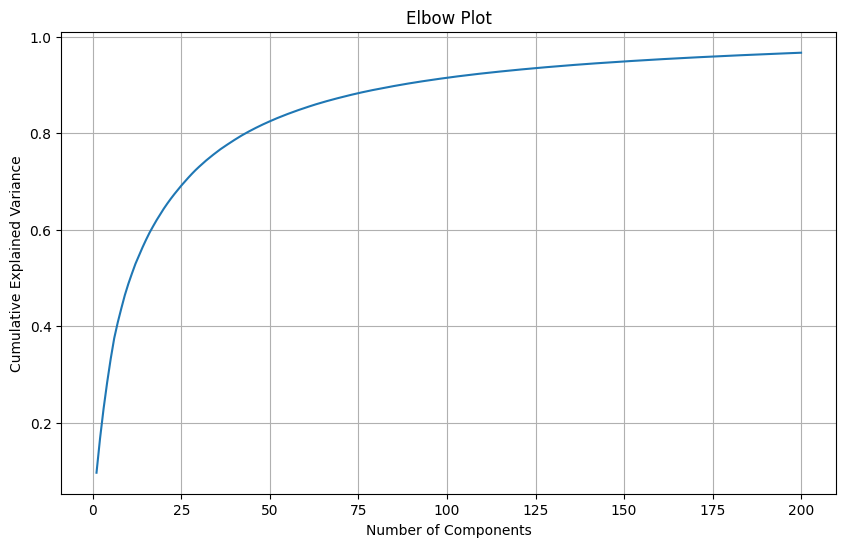

In [201]:
def plot_elbow_curve(explained_variance_ratio, max_components=200):
    cum_explained_variance = np.cumsum(explained_variance_ratio[:max_components])
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), cum_explained_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Elbow Plot')
    plt.grid()
    plt.show()

plot_elbow_curve(explained_variance_ratio)

In [ ]:
train_data_matrix.size()


In [202]:
class ProbabilisticPCA(torch.nn.Module):
    def __init__(self, n_components):
        super(ProbabilisticPCA, self).__init__()
        self.W = torch.nn.Parameter(torch.randn(28 * 28, n_components) * 0.01, requires_grad=True)
        self.mu = torch.nn.Parameter(torch.zeros(1, 28 * 28), requires_grad=True)

    def forward(self, X):
        return (X - self.mu) @ self.W

    def reconstruct(self, Z):
        return Z @ self.W.t() + self.mu

In [203]:
def train_probabilistic_pca(train_data, n_components, learning_rate, num_epochs):
    model = ProbabilisticPCA(n_components)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        Z = model(train_data)
        reconstruction = model.reconstruct(Z)
        loss = torch.mean(torch.square(train_data - reconstruction))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

In [204]:
n_components = 100
learning_rate = 1e-3
num_epochs = 250

model = train_probabilistic_pca(train_data_matrix, n_components, learning_rate, num_epochs)
train_data_reduced = model(train_data_matrix).detach().numpy()

Epoch [10/250], Loss: 0.2689
Epoch [20/250], Loss: 0.2764
Epoch [30/250], Loss: 0.2377
Epoch [40/250], Loss: 0.2121
Epoch [50/250], Loss: 0.1895
Epoch [60/250], Loss: 0.1708
Epoch [70/250], Loss: 0.1556
Epoch [80/250], Loss: 0.1431
Epoch [90/250], Loss: 0.1324
Epoch [100/250], Loss: 0.1242
Epoch [110/250], Loss: 0.1174
Epoch [120/250], Loss: 0.1114
Epoch [130/250], Loss: 0.1061
Epoch [140/250], Loss: 0.1013
Epoch [150/250], Loss: 0.0971
Epoch [160/250], Loss: 0.0932
Epoch [170/250], Loss: 0.0896
Epoch [180/250], Loss: 0.0862
Epoch [190/250], Loss: 0.0830
Epoch [200/250], Loss: 0.0799
Epoch [210/250], Loss: 0.0771
Epoch [220/250], Loss: 0.0745
Epoch [230/250], Loss: 0.0720
Epoch [240/250], Loss: 0.0698
Epoch [250/250], Loss: 0.0676


In [205]:
# Get the labels for the training data
train_labels = trainset.targets.numpy()

test_data_reduced = model(test_data_matrix).detach().numpy()

# Get the labels for the test data
test_labels = testset.targets.numpy()

In [206]:
test_labels.shape


(10000,)

In [207]:
## h/t https://stackoverflow.com/questions/36522220/searching-a-sequence-in-a-numpy-array

def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    """

    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found

In [208]:
arr = test_labels
seq = np.array([4,4,9,2,5,4,7,6,7,9,0,5])
search_sequence_numpy(arr,seq)

array([116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

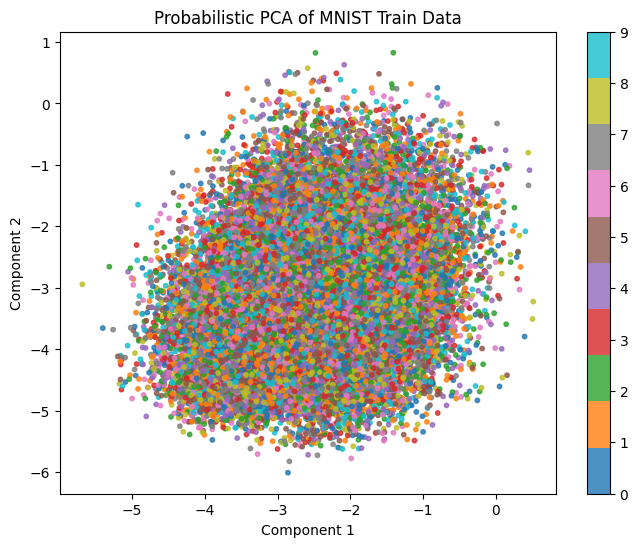

In [209]:
def plot_reduced_data(data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter)
    plt.show()

# Plot the reduced training data
plot_reduced_data(train_data_reduced, train_labels, 'Probabilistic PCA of MNIST Train Data')

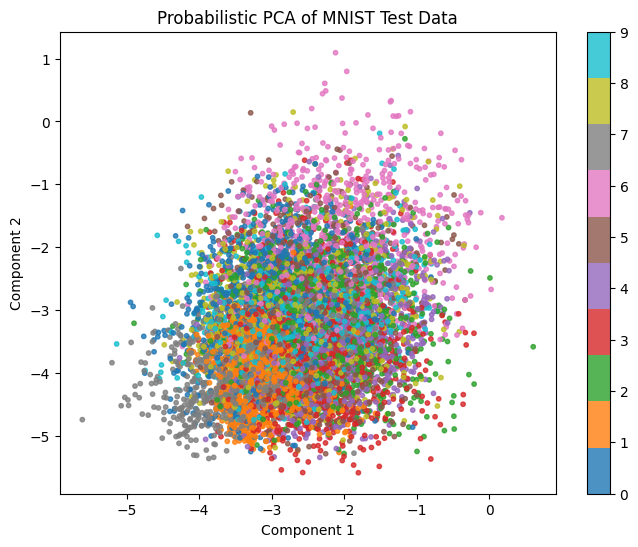

In [210]:
# Plot the reduced test data
plot_reduced_data(test_data_reduced, test_labels, 'Probabilistic PCA of MNIST Test Data')

In [211]:
reconstructed_test_data = model.reconstruct(torch.tensor(test_data_reduced)).detach().numpy()


In [212]:
def visualize_reconstructed_images(test_data, reconstructed_data, labels, num_samples=5):
    idx = np.random.choice(test_data.shape[0], num_samples, replace=False)
    original_images = test_data[idx].reshape(-1, 28, 28)
    reconstructed_images = reconstructed_data[idx].reshape(-1, 28, 28)
    label_samples = labels[idx]

    fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(2*num_samples, 4))

    for i, ax in enumerate(axes[0]):
        ax.imshow(original_images[i], cmap='gray')
        ax.set_title(f'Label: {label_samples[i]}')
        ax.axis('off')

    for i, ax in enumerate(axes[1]):
        ax.imshow(reconstructed_images[i], cmap='gray')
        ax.set_title('Reconstructed')
        ax.axis('off')

    plt.show()


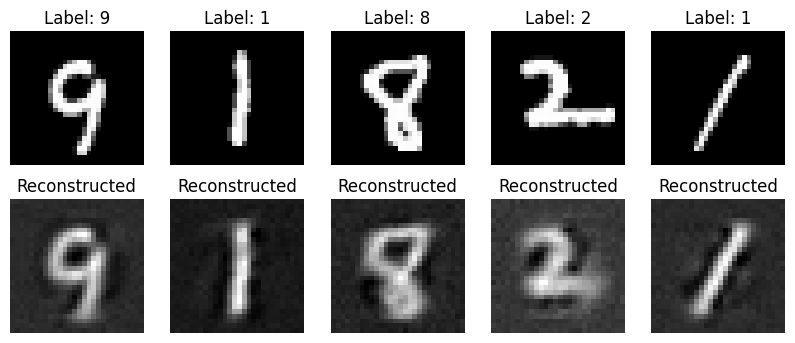

In [213]:
visualize_reconstructed_images(test_data_matrix.numpy(), reconstructed_test_data, test_labels)

## Test data plot

In [214]:
#original_images = test_data[idx].reshape(-1, 28, 28)

reconstructed_test_data = model.reconstruct(torch.tensor(test_data_reduced))
print(reconstructed_test_data.size())
print("The size of the test set is: " + str(reconstructed_test_data.size()))
#reconstructed_test_data = reconstructed_test_data[-12:,:]
reconstructed_test_data = reconstructed_test_data[116:128:,:]
print(reconstructed_test_data.size())

torch.Size([10000, 784])
The size of the test set is: torch.Size([10000, 784])
torch.Size([12, 784])


Ground truth images reformatted are of dimension torch.Size([1, 1, 28, 28])
Concatenated object containing both ground truth & generic VAE is of size torch.Size([1, 784])
Concatenated object also containing ConvNet VAE is of size torch.Size([15, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.FloatTensor


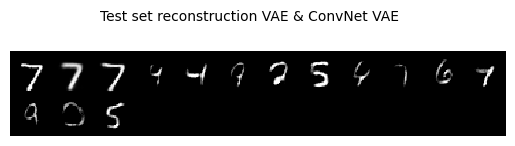

torch.Size([15, 1, 28, 28])


In [215]:
## now create an image of estimated images and ground truth
# h/t https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

## run first five training images through the encoder
### from https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.suptitle('Test set reconstruction VAE & ConvNet VAE', fontsize=10, y=.67)
    plt.axis('off')
    plt.show()

def plot_reconstruction(vae, n=12):
    
    x = test_images_ground_truth
    x = x[:n,:,:,:].to(device)
    print("Ground truth images reformatted are of dimension", x.size())
    try:
        out, _, _, log_p = vae(x.view(-1, image_size)) 
    except:
        out, _, _ = vae(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object containing both ground truth & generic VAE is of size", out.size())
    ## Conv Net
    out, mu, logVAR = net(x)
    x_concat = torch.cat([x_concat, out.view(-1, 1, 28, 28)], dim=0)
    ## Prob PCA
    x_concat = torch.cat([x_concat, reconstructed_test_data.view(-1, 1, 28, 28).to(device)], dim=0)

    
    
    print("Concatenated object also containing ConvNet VAE is of size", x_concat.size())

    print(out.size())
    print(out.type())
    ##
    out_grid = torchvision.utils.make_grid(x_concat, nrow=12)#.cpu().data
    show(out_grid)
    print(x_concat.size())

plot_reconstruction(vae)

# Create Prob PCA dataloader

In [217]:
torch.manual_seed(42)

# Define hyperparameters
batch_size = 64
epochs =30
learning_rate = 0.001

# Load the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [218]:
images = []
for batch in test_loader:
    images.append(batch[0])
test_images = torch.cat(images, dim=0)

test_labels = []
for _, label in test_loader:
    test_labels.append(label)
test_labels = torch.as_tensor(test_labels, dtype=torch.float)
test_labels = test_labels.type(torch.LongTensor)   # casting to long
print(len(test_labels))
print(test_labels.size())
print(test_labels.dtype)

10000
torch.Size([10000])
torch.int64


In [224]:
#original_images = test_data_matrix[idx].reshape(-1, 28, 28)
#reconstructed_images = reconstructed_test_data[idx].reshape(-1, 28, 28)
#label_samples = test_labels[idx]


original_images = test_data_matrix.reshape(-1, 28, 28)
reconstructed_test_data = model.reconstruct(torch.tensor(test_data_reduced))
reconstructed_images = reconstructed_test_data.reshape(-1, 28, 28)
label_samples = test_labels

print(original_images.size())
print(reconstructed_images.size())
print(label_samples.size())


torch.Size([10000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [225]:
'''
# Create an empty tensor to store the synthetic images
synthetic_images = torch.empty((len(test_loader), 1, 28, 28), dtype=torch.float32, device=device)

# Evaluate the Conv Net VAE model on the test dataset and generate synthetic images
net.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        synthetic_image = net(image)[0].squeeze()
        synthetic_images[i] = synthetic_image
'''

'\n# Create an empty tensor to store the synthetic images\nsynthetic_images = torch.empty((len(test_loader), 1, 28, 28), dtype=torch.float32, device=device)\n\n# Evaluate the Conv Net VAE model on the test dataset and generate synthetic images\nnet.eval()\nwith torch.no_grad():\n    for i, (image, label) in enumerate(test_loader):\n        image = image.to(device)\n        synthetic_image = net(image)[0].squeeze()\n        synthetic_images[i] = synthetic_image\n'

In [226]:
# h/t https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/
# set up DataLoader for training set
#synthetic_loader = DataLoader(list(zip(synthetic_images, test_labels)), shuffle=False, batch_size=100)
synthetic_loader = DataLoader(list(zip(reconstructed_images, label_samples)), shuffle=False, batch_size=100)
torch.save(synthetic_loader, "20230419_synthetic_Prob_PCA_loader.pth")


#Create Feed-forward Neural Network for supervised training - Prob PCA

In [227]:
torch.manual_seed(42)

# Define hyperparameters
batch_size = 64
epochs =30
learning_rate = 0.001

# Load the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [238]:
# Initialize the model, loss function, and optimizer
model = MNISTFeedForward()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [240]:
# Train the model
#model.hidden = model.init_hidden()
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(synthetic_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        #loss.backward(retain_graph=True)
        optimizer.step()

    print('Epoch [{} / {}], Loss: {:.4f}'.format(epoch + 1, epochs, loss.item()))

NameError: ignored

In [ ]:
# Evaluate the model
pca_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print('Accuracy on test dataset (called training): {:.2f}%'.format(accuracy))